we will focus on predicting fraudulent transactions from a given dataset. Due to the imbalanced nature of the data, standard classification metrics such as accuracy are not suitable for evaluation. Therefore, we will prioritize Sensitivity (true positive rate) and Specificity (true negative rate) as key performance metrics. Since these two metrics are interdependent, our objective is to identify the optimal trade-off between them. The ideal balance often depends on the specific use case, and for fraud detection, we emphasize achieving high sensitivity. This ensures that when a transaction is fraudulent, we can detect it with a high degree of certainty.


**IMPORTING LIBRARIES:**

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


In [3]:
from google.colab import files
uploaded = files.upload()


Saving creditcard.csv to creditcard.csv


**READING DATASET :**

This dataset is a popular one used for **credit card fraud detection**, and it’s particularly valuable because it closely mirrors the kind of real-world data analysts might encounter — **imbalanced, sensitive, and anonymized**.

---

### ✅ **Dataset Overview**

- **Source**: European cardholders’ transactions in **September 2013**, over **2 days**.
- **Total transactions**: **284,807**
- **Fraudulent transactions**: **492** (~0.172%) → **highly imbalanced**
- **Goal**: Detect fraudulent transactions (binary classification)

---

### ✅ **Column Descriptions**

| Column Name | Description | Use in Fraud Detection |
|-------------|-------------|------------------------|
| **Time** | Seconds since the first transaction | Could indicate patterns over time (e.g., fraud spikes at certain hours) |
| **V1 to V28** | Result of PCA (Principal Component Analysis) applied to original features | Used for pattern recognition; these preserve the most meaningful variance while protecting privacy |
| **Amount** | Transaction amount in euros | Can be used in cost-sensitive learning or to check for unusually large/small fraudulent transactions |
| **Class** | Target variable (0 = non-fraud, 1 = fraud) | **Label for classification** |

---

### ✅ **Key Notes on the Data**

- **PCA-transformed variables** (`V1` to `V28`) obscure original feature names but retain important statistical patterns.
- The **Time** feature helps track sequences or bursts of fraudulent activity.
- The **Amount** is not normalized — consider scaling it before training models.
- **Class** is what we predict — a binary value:
  - `0`: Genuine transaction
  - `1`: Fraudulent transaction

---

### ✅ **How Each Feature May Help in Detection**

| Feature | How It Might Be Useful |
|---------|------------------------|
| **Time** | Fraud may occur in bursts or off-hours — helpful for time-based clustering |
| **V1–V28** | Capture abstract patterns (e.g., frequency, vendor behavior, transaction fingerprint) |
| **Amount** | Unusual amounts may indicate fraud (e.g., high-value at strange times) |
| **Class** | Needed to train supervised models — tells the model what's fraud and what’s not |

---

### ✅ **How to Use This Dataset for Fraud Detection**

#### 1. **Preprocessing**
- Normalize or standardize `Amount`
- Check and handle class imbalance using:
  - **Undersampling/oversampling**
  - **SMOTE (Synthetic Minority Over-sampling Technique)**
- Optionally reduce `Time` to hour-of-day or session segments

#### 2. **Exploratory Data Analysis (EDA)**
- Plot class distribution
- Visualize fraud vs. non-fraud for features like `Amount`, `Time`
- Use `pairplot` or t-SNE to visualize PCA features

#### 3. **Modeling**
- Use classification models:
  - Logistic Regression
  - Decision Trees
  - Random Forests
  - XGBoost
  - Neural Networks
- Use **cross-validation** due to data imbalance

#### 4. **Evaluation**
- **Do NOT use only accuracy** due to imbalance
- Focus on:
  - **Precision**
  - **Recall**
  - **F1-score**
  - **AUC-PR (Precision-Recall Area Under Curve)**

---

### ✅ Summary of Columns (Quick Recap)

| Column | Type | Description |
|--------|------|-------------|
| `Time` | Numeric | Time since first transaction |
| `V1–V28` | Numeric | Principal components (PCA-transformed) |
| `Amount` | Numeric | Transaction amount |
| `Class` | Binary (0/1) | Fraud label (target variable) |

---



In [4]:

data = pd.read_csv('creditcard.csv')


In [9]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**NULL VALUES:**

In [ ]:
data.isnull().sum()

**Thus there are no null values in the dataset.**

**INFORMATION**

In [ ]:
data.info()

**DESCRIPTIVE STATISTICS**

In [12]:
data.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344


This data is a **summary of descriptive statistics** (like mean, standard deviation, min, max, quartiles, etc.) for several columns in the credit card fraud dataset — specifically for `Time`, `V1`, `V2`, `V3`, and `V4`.

---

### ✅ **Let’s break it down column-by-column:**

---

### 🔹 **Time**
| Statistic | Value | Meaning |
|-----------|-------|---------|
| Count | 284,807 | Number of transactions (matches total dataset) |
| Mean | 94,813.86 | Average time in seconds since the first transaction |
| Std Dev | 47,488.15 | High variability — transactions span a wide time window |
| Min | 0.0 | First transaction |
| 25% (Q1) | 54,201.5 | 25% of transactions happened before ~15 hours |
| 50% (Median) | 84,692.0 | Half of transactions happened before ~23.5 hours |
| 75% (Q3) | 139,320.5 | 75% of transactions happened within ~38.7 hours |
| Max | 172,792.0 | Last recorded transaction |

🔍 **Insight**: Transactions span ~2 days (which aligns with the dataset description). You might consider breaking `Time` into "hour of day" or "session blocks" to analyze fraud trends over time.

---

### 🔹 **V1 to V4**  
These are PCA-transformed features (you don’t know what they represent originally, but you can treat them like any other numeric feature).

#### 🔸 Common stats for V1, V2, V3, V4:

| Stat | Meaning |
|------|---------|
| **Mean ≈ 0** | PCA centering — data is zero-centered during transformation |
| **Std Dev** | Spread of values (how varied they are) |
| **Min / Max** | Indicates outliers or extreme values |
| **25% / 50% / 75%** | Show how data is distributed (skewness, spread, etc.)

#### 🔹 Notable individual insights:

- **V1**
  - Range: from -56.4 to +2.45 → Very **left-skewed**
- **V2**
  - Range: -72.7 to +22 → Also **left-skewed**, may hold strong anomaly signals
- **V3**
  - Range: -48.3 to +9.38 → Could also have extreme values used in fraud detection
- **V4**
  - Slightly more symmetric, smaller min/max range than others

📊 **Conclusion**:  
These PCA features are not human-interpretable but are crucial for the model. Their **spread and extreme values** might correlate strongly with fraud, especially if fraud examples tend to deviate significantly in one or more components.

---

### ✅ **Usage in Fraud Detection**

You’ll use these stats to:

- **Understand distribution** for preprocessing (e.g., scale features, detect outliers)
- Use **correlation or feature importance** to identify which components are useful
- Possibly **reduce dimensionality further** if some components have low variance
- Consider using **visualization (boxplots, histograms)** to compare fraud vs. non-fraud behavior for these features

---



In [13]:
data.shape

(284807, 31)

**Thus there are 284807 rows and 31 columns.**

In [14]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

**FRAUD CASES AND GENUINE CASES**

In [15]:
fraud_cases=len(data[data['Class']==1])

In [16]:
print(' Number of Fraud Cases:',fraud_cases)

 Number of Fraud Cases: 492


In [17]:
non_fraud_cases=len(data[data['Class']==0])

In [18]:
print('Number of Non Fraud Cases:',non_fraud_cases)

Number of Non Fraud Cases: 284315


In [19]:
fraud=data[data['Class']==1]

In [20]:
genuine=data[data['Class']==0]

In [21]:
fraud.Amount.describe()

,Amount
count,492.000000
mean,122.211321
std,256.683288
min,0.000000
25%,1.000000
50%,9.250000
75%,105.890000
max,2125.870000


In [22]:
genuine.Amount.describe()

,Amount
count,284315.000000
mean,88.291022
std,250.105092
min,0.000000
25%,5.650000
50%,22.000000
75%,77.050000
max,25691.160000


**EDA**

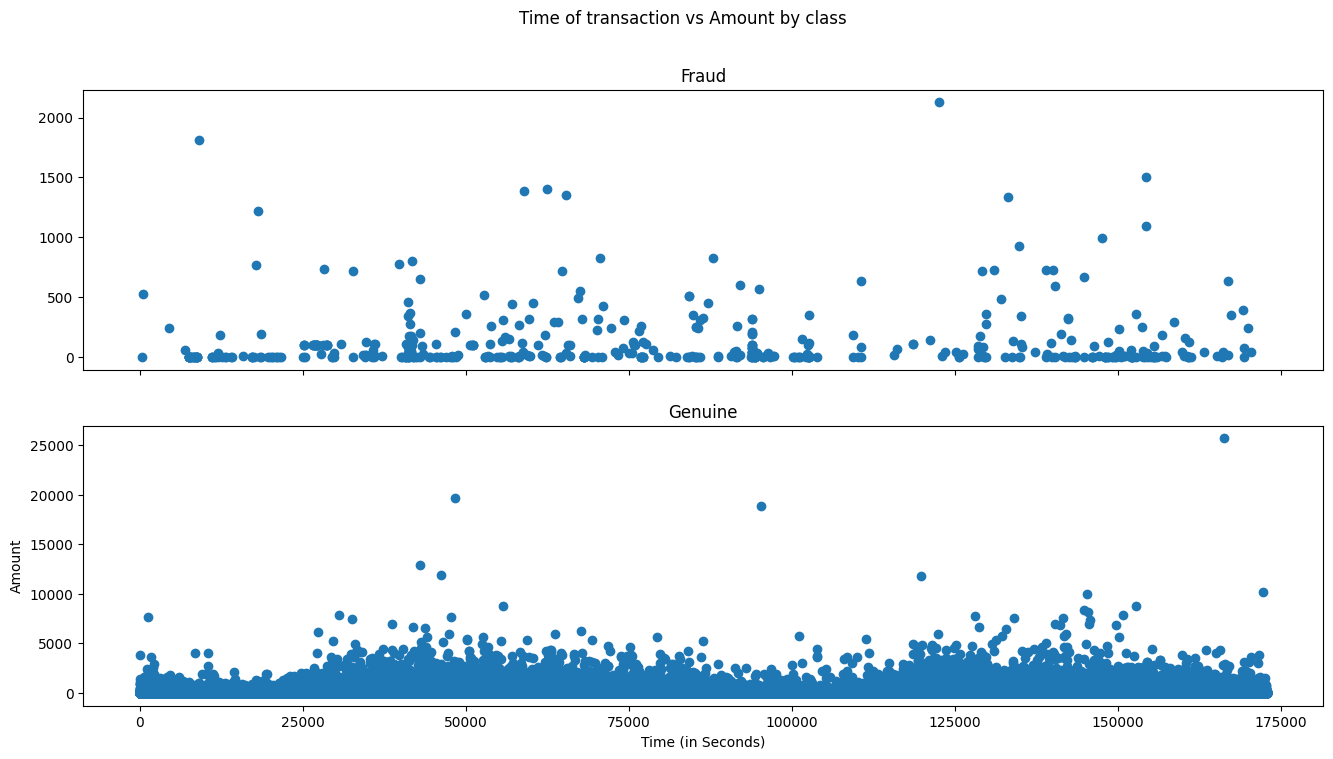

In [24]:
rcParams['figure.figsize'] = 16, 8
f,(ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(genuine.Time, genuine.Amount)
ax2.set_title('Genuine')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()




> **"Time of transaction vs Amount by class"**

This visualization separates transactions into two categories:
1. **Fraudulent transactions (top plot)**
2. **Genuine transactions (bottom plot)**

---

## 🔹 Understanding the Axes

- **X-axis (Time)**:  
  Represents the number of seconds since the first transaction in the dataset.  
  - Since it's in seconds, the range (0 to ~172,792 seconds) roughly corresponds to **2 days**.
  - This allows us to analyze **temporal patterns** — i.e., when transactions occur across the day(s).

- **Y-axis (Amount)**:  
  Shows the transaction amount in monetary units (e.g., dollars or rupees, depending on the dataset).

---

## 🔍 Detailed Breakdown of the Two Classes

### 🟥 1. Fraudulent Transactions (Top Plot)
---

#### ✅ **Observations:**

- **Transaction Amount Distribution**:
  - Most frauds are of **low amounts**, often **below ₹500**, with the majority even below ₹200.
  - Very few transactions cross the ₹1000 mark.
  - Maximum fraud amount is slightly above ₹2000.
  - This aligns with the idea that fraudsters may attempt to **avoid detection by keeping values low**.

- **Transaction Timing**:
  - Fraudulent transactions are **spread out over time**, without any significant visible pattern (e.g., no clear concentration during certain hours).
  - This indicates that fraud attempts are **randomly distributed** over the two-day period.

- **Density**:
  - The fraud plot appears **sparser** — consistent with the dataset's class imbalance, where frauds make up a very small percentage (≈0.17%).

#### ⚠️ **Interpretation**:

- Fraudsters **prefer smaller amounts**, possibly to go unnoticed.
- There’s **no distinct peak time** of fraudulent activity in this raw second-based representation.
- A few **outliers** exist — these high-value frauds might be sophisticated or involve stolen credentials.

---

### 🟦 2. Genuine Transactions (Bottom Plot)
---

#### ✅ **Observations:**

- **Transaction Amount Distribution**:
  - Legitimate transactions span a **wide range of amounts**, from very low to above ₹25,000.
  - High-value transactions (₹10,000+) are much more frequent in genuine ones than in frauds.

- **Transaction Timing**:
  - Dense clusters appear across the timeline, particularly:
    - **Between 0–75,000 seconds**
    - **Between 125,000–175,000 seconds**
  - This suggests that genuine transactions **occur more during active business hours**, which we could confirm by converting time to human-readable formats (e.g., hours or time of day).

- **Density & Spread**:
  - The genuine plot is **very dense** with thousands of data points. This reflects the natural volume of daily customer transactions.

#### ⚠️ **Interpretation**:

- Most legitimate transactions occur in a **structured pattern**, likely matching working hours or consumer activity cycles.
- Higher-value genuine transactions **don’t raise red flags**, unlike in the fraud plot where high values are very rare.
- Since there's **no overlap in values/times visible here**, classifying based on these two features alone may not be enough.

---

## 🧠 Key Takeaways

| Aspect                | Fraud Transactions                        | Genuine Transactions                       |
|----------------------|-------------------------------------------|--------------------------------------------|
| **Volume**            | Very low (~492 out of 284,807 total)     | Extremely high (the rest of the dataset)   |
| **Amount Range**      | Mostly small, under ₹500                 | Very broad, up to ₹25,000+                 |
| **Timing**            | Randomly scattered                       | Clustered, possibly aligned with human activity |
| **Outliers**          | Few high-value ones, rare                | Multiple high-value, normal                |
| **Behavior**          | Concealed, potentially automated         | Natural, human-driven patterns             |

---



**Let us build our models:**

In [36]:
from sklearn.model_selection import train_test_split

**Model 1:**

In [37]:
# Step 1: Train-test split
X = data.drop(['Class'], axis=1)
y = data['Class']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)












In [38]:
# Step 2: Train model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
model = rfc.fit(X_train, y_train)

In [39]:
# Step 3: Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


In [40]:
# Step 4: Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")


✅ Accuracy: 0.9995


In [41]:
# Step 5: Fraud detection stats
total_frauds = sum(y_test)
detected_frauds = sum((y_pred == 1) & (y_test == 1))
missed_frauds = total_frauds - detected_frauds
print(f"\n🔍 Total Fraud Cases in Test Set: {total_frauds}")
print(f"✅ Frauds Detected: {detected_frauds}")
print(f"❌ Frauds Missed: {missed_frauds}")



🔍 Total Fraud Cases in Test Set: 160
✅ Frauds Detected: 128
❌ Frauds Missed: 32


In [44]:
# Step 6: Classification Report & Confusion Matrix
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85283
           1       0.95      0.80      0.87       160

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443

🧮 Confusion Matrix:
[[85276     7]
 [   32   128]]


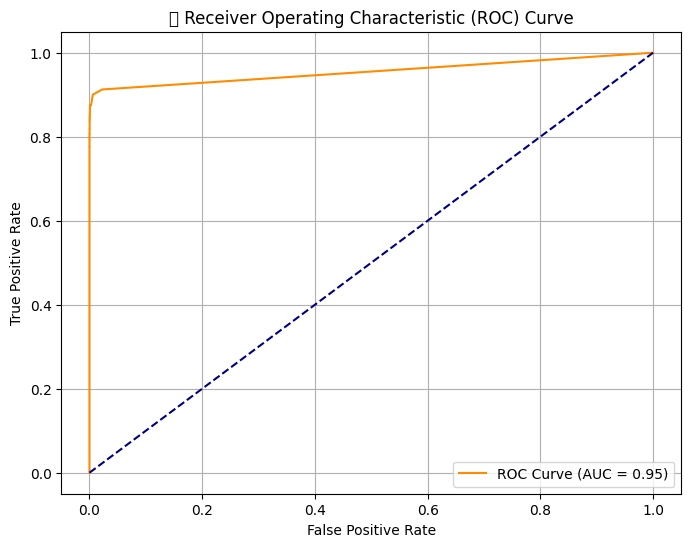

In [45]:
# Step 7: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

This is a **ROC (Receiver Operating Characteristic) curve**, and it’s used to evaluate the performance of a classification model—especially when the classes are imbalanced, which is very typical in fraud detection datasets. Here's a breakdown of what your ROC curve tells us:

---

### 📈 **Interpretation of the Curve**
- **X-axis:** False Positive Rate (FPR) – how often the model falsely predicts fraud when it’s actually genuine.
- **Y-axis:** True Positive Rate (TPR) – how often the model correctly predicts fraud.
- **Orange Curve:** This shows the trade-off between TPR and FPR at different thresholds.
- **Diagonal Line (dashed):** This is the baseline representing a random guess. A model performing along this line has no discriminatory power.

---

### ⭐ **AUC (Area Under the Curve) = 0.95**
- The **AUC** value ranges between **0 and 1**.
  - **0.5**: Model performs no better than random.
  - **> 0.7**: Decent.
  - **> 0.85**: Very good.
  - **> 0.95**: Excellent!

- Your model's **AUC = 0.95**, which means:
  - It can **distinguish between fraud and genuine transactions with high accuracy**.
  - The **true positive rate stays high while keeping false positives low**—ideal for fraud detection.

---



**Model 2:**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X1=data.drop(['Class'],axis=1)

In [ ]:
y1=data['Class']

In [ ]:
X1_train,X1_test,y1_train,y1_test=train_test_split(X1,y1,test_size=0.3,random_state=123)

In [ ]:
lr=LogisticRegression()

In [ ]:
model2=lr.fit(X1_train,y1_train)

In [ ]:
prediction2=model2.predict(X1_test)

In [ ]:
accuracy_score(y1_test,prediction2)

0.9988764439450862